In [1]:
#Can we get plots of first betas?
#Shows each individual plot along with which model best fits it
import pickle, math
import pandas as pd
import sqlite3
import random
import os
import itertools
exec(open('Imports.py').read()) #execfile('Imports.py')
exec(open('ImportModels.py').read())
import Modules.Funcs as funcs
# from Modules.Classes import Simulation
# from Modules.Classes import CopyTweak
# from Modules.Classes import CopyTweakRep
# from Modules.Classes import Packer
# from Modules.Classes import PackerRep
# from Modules.Classes import PackerEuc
# from Modules.Classes import ConjugateJK13
# from Modules.Classes import RepresentJK13
from scipy.stats import stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#plotting options
STAT_LIMS =  (-1.0, 1.0)
#Fit to only last trial?
fitlast = False
#Make plots?
doplots = True
saveplots = False
if fitlast:
    showlast = True
else:
    showlast = False #True = Show last even if fitting to all?
#Bootstrap parameters
nbootstraps = 1000

#Some plotting options
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 15}

#Specify simulation values
N_SAMPLES = 10000
WT_THETA = 1.5
MIN_LL = 1e-10

# Specify default dataname
dbname = 'experiment-corner.db'#'experiments-5con.db'#raw data
dataname_def = 'corner'#'5con'#bestparms comes from here

# Specify default dataname
# dataname_def = 'pooled'#'nosofsky1986'#'NGPMG1994'
participant_def = 'all'
unique_trials_def = 'all'
dataname = dataname_def
execfile('validate_data.py')

bestparmdb = "pickles/chtc_gs_best_params_{}".format(src)


plt.rc('font', **font)

# get data from pickle
with open(pickledir+src, "rb" ) as f:
    trials = pickle.load( f )

with open(bestparmdb, "rb" ) as f:
    best_params_t = pickle.load( f )

#Rebuild parms into a smaller dict
best_params = dict()
for modelname in best_params_t.keys():    
    best_params[modelname] = dict()
    for i,parmname in enumerate(best_params_t[modelname]['parmnames']):
        parmval = best_params_t[modelname]['bestparmsll']
        best_params[modelname][parmname] = parmval[i]
modelList = [Packer,RepresentJK13]
#modelList = [CopyTweak,CopyTweakRep,Packer, RepresentJK13,]                            

#Specify plot order
modelPlotOrder = np.array([[Packer,RepresentJK13],[CopyTweak,ConjugateJK13]])
     
unique_trials = 'all'
trials.task = task

#Create new trialset
con = sqlite3.connect(dbname)
participants = pd.read_sql_query("SELECT participant, condition from participants", con)
generation = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values
con.close()





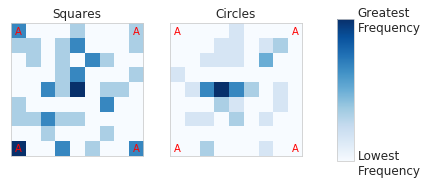

In [2]:
firsts = []
firsts += [generation.loc[(generation.wrap_ax!=1.0) & (generation.trial==0),'stimulus']] #Squares
firsts += [generation.loc[(generation.wrap_ax==1.0) & (generation.trial==0),'stimulus']] #Circles
#Convert to ps
ps = []
f,ax = plt.subplots(1,len(firsts),figsize=(3*len(firsts),3))
A = alphas.Corner_C.values
As = stimuli[A]
titles = ['Squares','Circles']
for i,first in enumerate(firsts):
    freq = first.value_counts(normalize=True,sort=False).sort_index()
    p = np.zeros(len(stimuli))
    p[freq.keys()] = freq.values
    ps += [p]    
    gps = funcs.gradientroll(p,'roll')[:,:,0]
    ps_ElRange = gps.max()-gps.min();
    plotVals = (gps-gps.min())/ps_ElRange
    gammas = []
    im = funcs.plotgradient(ax[i], plotVals, As, [], gammas = gammas,clim = [0,1], cmap = 'Blues',beta_col='green')
    ax[i].set_title(titles[i])
# add colorbar
f.subplots_adjust(right=0.8)
cbar = f.add_axes([0.88, 0.17, 0.04, 0.66])
cb = f.colorbar(im, cax=cbar, ticks = [0,1])#,boundaries=np.unique(plotVals))
cbar.set_yticklabels(['Lowest\nFrequency', 'Greatest\nFrequency'],fontsize=12)
# cb = f.colorbar(im, cax=cbar, ticks = np.unique(plotVals),boundaries=np.unique(plotVals))
# cbar.set_yticklabels(range(6),fontsize=10)
cbar.tick_params(length = 0)

if saveplots:
    plt.savefig('private/firstbetas_cornerbehav.pdf',bbox_inches='tight')

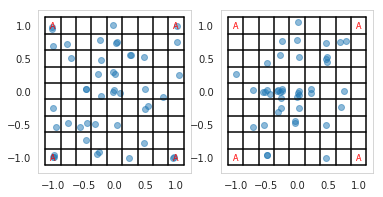

In [3]:
firsts = []
firsts += [generation.loc[(generation.wrap_ax!=1.0) & (generation.trial==0),'stimulus']] #Squares
firsts += [generation.loc[(generation.wrap_ax==1.0) & (generation.trial==0),'stimulus']] #Circles
#Convert to ps
ps = []
f,ax = plt.subplots(1,len(firsts),figsize=(3*len(firsts),3))
A = alphas.Corner_C.values
As = stimuli[A]
step = .25
adj = - step/2
for i,first in enumerate(firsts):
    stimvals = stimuli[first]
    #Add jitter
    stimvals = funcs.jitterize(stimvals,sd=.03)
    ax[i].scatter(stimvals[:,0],stimvals[:,1],alpha=.5)
    stepx = np.unique(stimuli[:,0]) + adj
    stepy = np.unique(stimuli[:,1]) + adj
    stepx = np.append(stepx,max(stepx)+step)
    stepy = np.append(stepy,max(stepy)+step)
    for pi,xx in enumerate(stepx):
        ax[i].grid(False)
        ax[i].plot([xx,xx],[min(stepy),max(stepy)],'k-')        
        ax[i].plot([min(stepx),max(stepx)],[xx,xx],'k-')
        for AsEl in As:
            ax[i].text(AsEl[0],AsEl[1],'A',color='red',
                       horizontalalignment='center',verticalalignment='center',
                      alpha=.15,
                      fontsize=8)


{'category_variance_bias': 4.0706961282242596e+20, 'determinism': 0.725392401354471, 'category_mean_bias': 1.0014877864883311e-10, 'domain_variance_bias': 0.13740177759888955}
Outer edges: 0.45
Inner spaces: 0.55


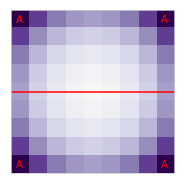

In [4]:
##Probabilities at outer edge vs inner space - Rep
steps = 9
vals = np.linspace(-1, 1,steps).tolist()
space = np.fliplr(funcs.cartesian([vals, vals]))
st = 2./(steps-1)

wrap_ax=None
outind = range(steps) + [(e+1)*steps for e in range(steps-2)] + [(e+1)*steps+steps-1 for e in range(steps-2)] + range(steps**2-steps,steps**2)
innind = [i for i in range(steps**2) if not i in outind]
model = RepresentJK13
params = best_params[model.model]
# params['category_mean_bias']=0
categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]

# categories1 = [np.array([[-1,-1],[1,-1],[-1,1],[1,1]])]

# categories1 = [np.array([[-1,-.5],[1,-.5],[-1,-.75],[1,-.75]])]
temp1 = model(categories1,params,wrap_ax=wrap_ax,stimstep=[st,st]).get_generation_ps(space,1,'generate')
outps = sum(temp1[outind])
innps = sum(temp1[innind])
# print(np.round(np.reshape(temp1,(9,9)),3))
print(params)
print('Outer edges: ' + str(np.round(outps,2)))
print('Inner spaces: ' + str(np.round(innps,2)))
temp11= np.reshape(temp1,(steps,steps))
midtemp = (steps+1)/2 - 1
oneup = temp11[midtemp+1][0]
onedn = temp11[midtemp-1][0]
# print(oneup)
# print(onedn)
# print(oneup-onedn)
f,ax = plt.subplots(1,1,figsize=(3,3))
gps = funcs.gradientroll(temp1,'roll')[:,:,0]
ps_ElRange = gps.max()-gps.min();
plotVals = (gps-gps.min())/ps_ElRange
gammas = []
funcs.plotgradient(ax, plotVals, categories1[0], [], gammas = gammas,clim = STAT_LIMS, cmap = 'PuOr',beta_col='green')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
yhalf = np.mean(ylim)
ax.plot(xlim,[yhalf,yhalf],'r-')

PACKER - Outer edges: 0.06, Max: 0.0004
PACKER - Inner spaces: 0.94, Max: 0.0005
Representative - Outer edges: 0.09, Max: 0.0005
Representative - Inner spaces: 0.91, Max: 0.0005
PACKER - Outer edges: 0.05, Max: 0.0004
PACKER - Inner spaces: 0.95, Max: 0.0006
Max wrapped axis reached. Up density ratio = 1.00000
Max wrapped axis reached. Down density ratio = 1.00000
Representative - Outer edges: 0.06, Max: 0.0012
Representative - Inner spaces: 0.94, Max: 0.0012


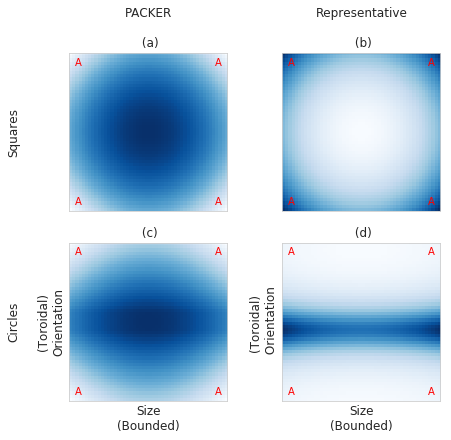

In [5]:
# Probabilities at outer edge vs inner space - Rep

steps = 50
vals = np.linspace(-1, 1,steps).tolist()
space = np.fliplr(funcs.cartesian([vals, vals]))
st = 2./(steps-1)

models = [Packer,RepresentJK13]
f,ax = plt.subplots(2,len(models),figsize=(7,3.2*len(models)))
wraps = [None,1]
labels = [['a','b'],['c','d']]
for wi,wrap_ax in enumerate(wraps):
    for mi,model in enumerate(models):
        outind = range(steps) + [(e+1)*steps for e in range(steps-2)] + [(e+1)*steps+steps-1 for e in range(steps-2)] + range(steps**2-steps,steps**2)        
        innind = [i for i in range(steps**2) if not i in outind]
        params = best_params[model.model]
        categories1 = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]
        temp1 = model(categories1,params,wrap_ax=wrap_ax).get_generation_ps(space,1,'generate')
        outps = sum(temp1[outind])
        innps = sum(temp1[innind])
        maxout = max(temp1[outind])
        maxin = max(temp1[innind])
        print('{} - Outer edges: {}, Max: {}'.format(model.modelshort,np.round(outps,2),np.round(maxout,4)))
        print('{} - Inner spaces: {}, Max: {}'.format(model.modelshort, np.round(innps,2),np.round(maxin,4)))
        gps = funcs.gradientroll(temp1,'roll')[:,:,0]
        ps_ElRange = gps.max()-gps.min();
        plotVals = (gps-gps.min())/ps_ElRange
        gammas = []
        categories1[0] = [[-.9,-.9],[-.9,.9],[.9,-.9],[.9,.9]]
        funcs.plotgradient(ax[wi,mi], plotVals, categories1[0], [], gammas = gammas,clim = [0,1], cmap = 'Blues',beta_col='green')
        if wi==0:
            modeln = model.modelshort 
            if mi==0:
                ax[wi,mi].set_ylabel('Squares\n\n\n',fontsize=12)
        else:
            modeln = ''
            if mi==0:
                ax[wi,mi].set_ylabel('Circles\n\n(Toroidal)\nOrientation',fontsize=12)
            else:
                ax[wi,mi].set_ylabel('(Toroidal) \n Orientation',fontsize=12)
            ax[wi,mi].set_xlabel('Size\n(Bounded)',fontsize=12)
        
        #titlestr = '%s\nOuter edges: %.2f \nInner spaces: %.2f' % (modeln,outps,innps)
        titlestr = '%s\n\n (%s)'% (modeln,labels[wi][mi])
        ax[wi,mi].set_title(titlestr,fontsize=12)
        
if saveplots:
    plt.savefig('private/firstbetas_cornerPostfits50.pdf',bbox_inches='tight')

Data Squares corr x = -0.496139, p = 0.395265
Data Squares corr y = -0.310575, p = 0.611016
PACKER Squares corr x = -0.963499, p = 0.008325
PACKER Squares corr y = -0.963499, p = 0.008325
Representative Squares corr x = 0.950367, p = 0.013175
Representative Squares corr y = 0.950367, p = 0.013175


Data Circles corr x = -0.948487, p = 0.013926
Data Circles corr y = -0.744589, p = 0.148872
PACKER Circles corr x = -0.966840, p = 0.007212
PACKER Circles corr y = -0.992998, p = 0.000703
Max wrapped axis reached. Up density ratio = 1.00000
Max wrapped axis reached. Down density ratio = 1.00000
Representative Circles corr x = 0.950367, p = 0.013175
Representative Circles corr y = -0.919291, p = 0.027189




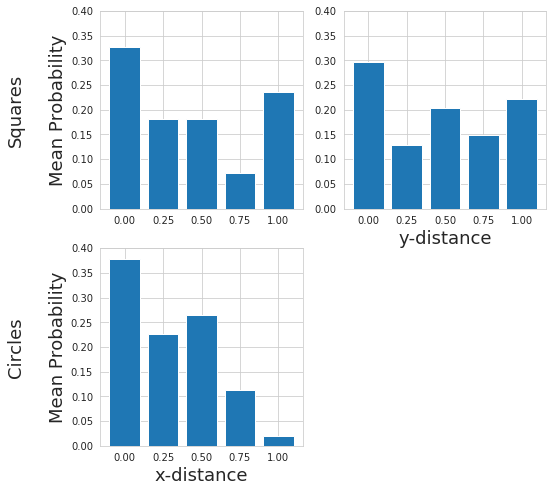

In [10]:
#Get distances from center
from scipy.stats import pearsonr
center = np.array([0,0])
f,ax = plt.subplots(2,2,figsize=(8,8))
models = [Packer,RepresentJK13]#,RepresentJK13]
modelc = ['r','g']
modelm = ['x','o']
ys = ['Squares','Circles']
categories = [np.array([[-1.,-1.],[1.,-1.],[-1.,1.],[1.,1.]])]
wraps = [None,1]
bwidth = .2 #.1#bar width
fs = 18


for i,first in enumerate(firsts):
    for mi,model in enumerate(models):
        params = best_params[model.model]
        #firsts: squares, then circles, plotted as rows
        wrap_ax = wraps[i]
        stimvals = stimuli[first]
        distances = np.abs(stimvals)
        distx = distances[:,0]
        disty = distances[:,1]
        if mi==0:
            #Normalize them so they sum to 1
            #Bin them manually
            distxu = np.unique(distx)
            distyu = np.unique(disty)
            n_max =  [1]+[2 for _ in range(len(distxu)-1)]#adjust for there being twice as many edges as centers (i.e., there is only one clumn of 0s, but .25,.5,.75, and 1 needs to be averaged)
            nx = np.array([np.count_nonzero(distx==x) for x in distxu],dtype=float)/n_max
            ny = np.array([np.count_nonzero(disty==y) for y in distyu],dtype=float)/n_max
            #Normalise so bins sum to 1
            nxp = nx/sum(nx)
            nyp = ny/sum(ny)
#             ax[i,0].bar(distxu,nxp,width=bwidth,color='None',edgecolor='k')
#             ax[i,1].bar(distyu,nyp,width=bwidth,color='None',edgecolor='k')
            ax[i,0].bar(distxu,nxp,width=bwidth)
            ax[i,1].bar(distyu,nyp,width=bwidth)    
            datarx = pearsonr(nxp,distxu)
            datary = pearsonr(nyp,distyu)
            print('Data %s corr x = %f, p = %f'%(ys[i],datarx[0],datarx[1]))
            print('Data %s corr y = %f, p = %f'%(ys[i],datary[0],datary[1]))
            
#             mx = datarx[0]*np.std(nxp)/np.std(distxu)#np.cov(distxu,nxp)[0,1]
#             cx = np.mean(nxp) - mx*(np.mean(distxu))
    
#             my = datary[0]*np.std(nyp)/np.std(distyu)#np.cov(distxu,nxp)[0,1]
#             cy = np.mean(nyp) - my*(np.mean(distyu))
#             ax[i,0].plot([0,1],[cx,cx+mx],'-')
#             ax[i,1].plot([0,1],[cy,cy+my],'-')

            #Try other distance metrics?
#             distc = np.sum(distances,axis=1) #city block
#             diste = np.sqrt(np.sum(distances**2,axis=1)) #Euclidean
#             datac = pearsonr(distc)
#             print('Data %s corr city = %f, p = %f'%(ys[i],datarc[0],datarc[1]))
#             print('Data %s corr euc = %f, p = %f'%(ys[i],datare[0],datare[1]))

        # Get model predictions
        ps = model(categories,params,wrap_ax=wrap_ax).get_generation_ps(stimuli,1,'generate')                
        distsp = np.abs(stimuli)
        distxp = distsp[:,0]
        distyp = distsp[:,1]
        #Get average ps?
        distxpu = np.unique(distxp)
        distypu = np.unique(distyp)
        psxu = np.array([np.mean(ps[distxp==x]) for x in distxpu])
        psyu = np.array([np.mean(ps[distyp==y]) for y in distypu])
        #Normalize them so they sum to 1
        psxu = np.array(psxu)/np.sum(psxu)
        psyu = np.array(psyu)/np.sum(psyu)
#         ax[i,0].scatter(distxpu,psxu,c=modelc[mi],marker=modelm[mi],zorder=2)
#         ax[i,1].scatter(distypu,psyu,c=modelc[mi],marker=modelm[mi],zorder=2)
        #label axes
        ax[i,0].set_ylabel('{}\n\nMean Probability'.format(ys[i]),fontsize=fs)
        #Set ylims
        ax[i,0].set_ylim([0,.4])
        ax[i,1].set_ylim([0,.4])
        ax[i,1].set_xlabel('y-distance',fontsize=fs)
        if i==1:
            ax[i,0].set_xlabel('x-distance',fontsize=fs)
            ax[i,1].set_xlabel('y-distance',fontsize=fs)
        #Print errors
        ss_errx = sum((psxu-nxp)**2)
        ss_erry = sum((psyu-nyp)**2)
#         print('%s %s error x = %f'%(model.modelshort,ys[i],ss_errx))
#         print('%s %s error y = %f'%(model.modelshort,ys[i],ss_erry))
#         print('%s %s error Total = %f'%(model.modelshort,ys[i],ss_errx+ss_erry))
        prx = pearsonr(psxu,distxpu)
        pry = pearsonr(psyu,distypu)
        print('%s %s corr x = %f, p = %f'%(model.modelshort,ys[i],prx[0],prx[1]))
        print('%s %s corr y = %f, p = %f'%(model.modelshort,ys[i],pry[0],pry[1]))
        

    print('\n')
ax[1,1].set_visible(False)
# ax[0,1].legend({'Packer','Rep'},fontsize=14)        
plt.savefig('private/firstbetas_distcent.pdf',bbox_inches='tight')
#plt.savefig('private/firstbetas_distcentModelOverlay.pdf')

In [16]:
covx = np.cov(nx,distxu)
covx

array([[13.45   , -1.375  ],
       [-1.375  ,  0.15625]])

In [113]:
np.

AttributeError: 'numpy.ndarray' object has no attribute 'index'

(-0.31887841176965037, 0.4029440749521745)
(-0.8325610746094635, 0.005347312272836135)


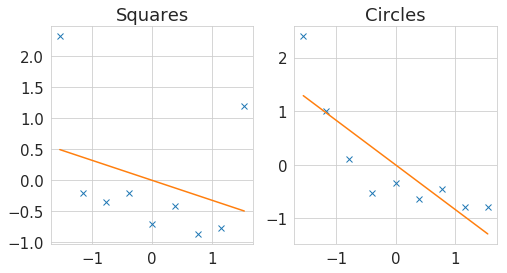

In [173]:
dmetric = lambda x : np.sum(x,axis=1)
f,ax = plt.subplots(1,len(firsts),figsize=(8,4))
ys = ['Squares','Circles']
for fi,first in enumerate(firsts):
    #Get each possible discrete distance
    discrete_steplen = .25
    discrete_step1d = np.arange(0,1.1,.25) #end at 1.1 because I want to count the endpoint
    possdist = []
    for step1 in discrete_step1d:
        for step2 in discrete_step1d:
            one_dist = dmetric(np.abs([[step1,step2]]))
            if not one_dist in possdist:
                possdist += [dmetric(np.abs([[step1,step2]]))[0]]
    possdist = np.sort(possdist)
    alldist = dmetric(np.abs(stimuli))
    possdist_n = []
    for pd in possdist:        
        possdist_n += [np.count_nonzero(pd==alldist)]
    distc_raw = dmetric(np.abs(stimuli[first]))
#     distc_raw = distc_raw/.25
    distcn = [np.count_nonzero(distc_raw==u) for u in np.unique(distc_raw)]
    distci = [np.where(possdist==u)[0][0] for u in np.unique(distc_raw)]
    distc = np.zeros(len(possdist_n))
    distc[distci] = distcn
    #Divide by number of squares/locations at all possible distances
    distc = distc/np.array(possdist_n)
    distc = funcs.softmax(distc,toggle=False)
    (r,p) = pearsonr(distc,possdist)
    print(pearsonr(distc,possdist))
    ax[fi].set_title(ys[fi])
#     ax[fi].set_ylim([0,.5])
    #Standardise them?
    possdiststd = (possdist-np.mean(possdist))/np.std(possdist)
    distcstd = (distc-np.mean(distc))/np.std(distc)
    ax[fi].plot(possdiststd,distcstd,'x')
    x = np.array([min(possdiststd),max(possdiststd)])
    y = r*x
    ax[fi].plot(x,y)

(-0.3697560085326553, 0.17494421023047826)
(-0.7866838378633806, 0.0005027202438892905)


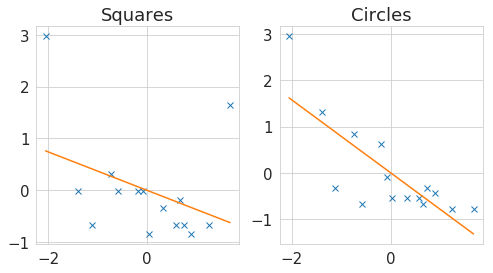

In [190]:
#Try Euclidean distance
dmetric = lambda x : np.sqrt(np.sum(x**2,axis=1))
f,ax = plt.subplots(1,len(firsts),figsize=(8,4))
ys = ['Squares','Circles']
for fi,first in enumerate(firsts):
    #Get each possible discrete distance
    discrete_steplen = .25
    discrete_step1d = np.arange(0,1.1,.25) #end at 1.1 because I want to count the endpoint
    possdist = []
    for step1 in discrete_step1d:
        for step2 in discrete_step1d:
            one_dist = dmetric(np.abs([[step1,step2]]))
            if not one_dist in possdist:
                possdist += [dmetric(np.abs([[step1,step2]]))[0]]
    possdist = np.sort(possdist)
    alldist = dmetric(np.abs(stimuli))
    possdist_n = []
    for pd in possdist:        
        possdist_n += [np.count_nonzero(pd==alldist)]
    distc_raw = dmetric(np.abs(stimuli[first]))
#     distc_raw = distc_raw/.25
    distcn = [np.count_nonzero(distc_raw==u) for u in np.unique(distc_raw)]
    distci = [np.where(possdist==u)[0][0] for u in np.unique(distc_raw)]
    distc = np.zeros(len(possdist_n))
    distc[distci] = distcn
    #Divide by number of squares/locations at all possible distances
    distc = distc/np.array(possdist_n)
    distc = funcs.softmax(distc,toggle=False)
    (r,p) = pearsonr(distc,possdist)
    print(pearsonr(distc,possdist))
    ax[fi].set_title(ys[fi])
#     ax[fi].set_ylim([0,.5])
    #Standardise them?
    possdiststd = (possdist-np.mean(possdist))/np.std(possdist)
    distcstd = (distc-np.mean(distc))/np.std(distc)
    ax[fi].plot(possdiststd,distcstd,'x')
    x = np.array([min(possdiststd),max(possdiststd)])
    y = r*x
    ax[fi].plot(x,y)

In [191]:
len(possdiststd)

15

In [164]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
fit = regr.fit(possdiststd.reshape(-1,1),distcstd.reshape(-1,1))
print(regr.intercept_,regr.coef_)
rr = pearsonr(distcstd,possdiststd)
testm = rr[0]*(np.std(distcstd)/np.std(possdiststd))

(array([-2.25202318e-16]), array([[-0.78668384]]))


In [167]:
pearsonr(distc,possdist)

(-0.7866838378633806, 0.0005027202438892905)

(array([ 6., 11.,  7., 12., 10.]),
 array([0.        , 0.28284271, 0.56568542, 0.84852814, 1.13137085,
        1.41421356]),
 <a list of 5 Patch objects>)

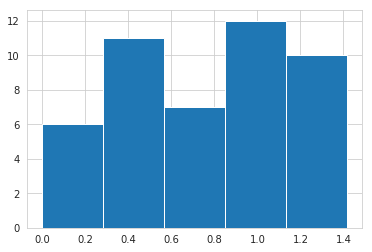

In [71]:
diste = np.sqrt(np.sum(np.abs(stimuli[firsts[0]])**2,axis=1))
plt.hist(diste,bins=5)

In [167]:
distc/.25

array([3., 1., 1., 2., 1., 4., 2., 0., 4., 4., 2., 2., 2., 2., 3., 6., 1.,
       5., 3., 1., 4., 4., 0., 3., 6., 6., 0., 0., 4., 5., 4., 4., 2., 1.,
       4., 1., 6., 5., 1., 6., 2., 1., 2.])

In [100]:
np.cov(nxp,distxu)

array([[ 0.01915272, -0.05188679],
       [-0.05188679,  0.15625   ]])

In [99]:
nxp

array([0.37735849, 0.22641509, 0.26415094, 0.11320755, 0.01886792])

0.15840342342251323
(0.9999921848534198, 2.6226421717577426e-08)


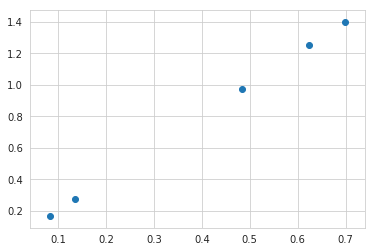

In [139]:
ma = 2
n = 5
a = np.random.uniform(size=n)#np.random.multivariate_normal([0,0],np.array([[1,.5],[.5,1]]),1000)
b = ma*a+np.random.normal(size=n)*.01
cova = np.cov(a,b)#np.cov(a[:,0],a[:,1])
print(cova[0,1])
cora = pearsonr(a,b)
print(cora[0],cora[1])
plt.scatter(a,b)

In [138]:
np.cov(distxu,nxp)

array([[ 0.15625   , -0.05188679],
       [-0.05188679,  0.01915272]])

In [155]:
spearmanr(nyp,(1,2,3,4,5))

SpearmanrResult(correlation=-0.8207826816681234, pvalue=0.08858700531354378)

In [146]:
nyp

array([0.59016393, 0.08196721, 0.18032787, 0.08196721, 0.06557377])

In [154]:
from scipy.stats import spearmanr
spearmanr((6,.1,2,.1,.05),range(5))

SpearmanrResult(correlation=-0.8207826816681234, pvalue=0.08858700531354378)